# Evaluation of Dst Geomagnetic Index

In this notebook, we evaluate the performance of the trained model in comparison to the benchmark established by [Licata et al. (2020)](https://doi.org/10.1029/2020sw002496). In their study, the authors assess the performance of the SOLAR2000 statistical model between the years 2012 and 2018 and provide insights into the performance of traditional models for space weather forecasting.

In [11]:
# Imports
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices() # fix to make the script work in the MIT supercloud
from swdf.benchmark import *
from tsai.basics import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
wandb_api = wandb.Api()

In [12]:
# Constants
ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/dst_eval_tmp"

In [13]:
# Config
config = yaml2dict('config/geodst.yaml')
config = config.eval
config

```json
{ 'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'round_preds': True,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'}
```

In [14]:
# TODO
# learn.path = Path(path)
# learn.model_dir = Path()
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)
learn = load_learner_all(learner_path, model_fname = 'model', 
                         verbose=True, 
                         device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [ ]:
y_test_preds, y_test, y_test_losses = learn.get_preds(ds_idx = 2, with_targs=True, with_loss=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}, y_test_losses (mean): {y_test_losses.mean()}")     

In [ ]:
if config.round_preds:
    y_test_preds = y_test_preds.round()
    print(f'Loss after rounding predictions: {learn.loss_func(totensor(y_test_preds), totensor(y_test))}')

Loss after rounding predictions: 446.55462646484375


In [ ]:
learn.validate(ds_idx = 2)

(#1) [446.4754333496094]

In [ ]:
# Get the average test loss
test_loss = y_test_losses.mean()
print(f"test_loss: {test_loss}")

test_loss: 446.4754638671875


In [ ]:
horizon = y_test.shape[-1]
horizon_days = int(np.ceil(horizon / 24))
data_columns_fcst = ['DST']
horizon, horizon_days

(144, 6)

In [ ]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")
df_dst = load_object("./preprocessed_data/dataframes/dst.pkl")

In [ ]:
df_F10['Datetime'] = df_F10['Datetime'] - pd.Timedelta(hours=12)

# Merge the DST and F10.7 dataframes on the datetime column, and keep only the columns we need
df_combined = pd.merge(df_dst, df_F10, on='Datetime', how='left')
df_combined = df_combined[['Datetime', 'DST', 'F10']]

# The F10 is given only at 12:00 (00:00 now that we shifted), so we'll forward 
# fill the rest of the values
df_combined['F10'] = df_combined['F10'].ffill()
df_combined.head()
df_combined

,Datetime,DST,F10
0,1957-01-01 00:00:00,11.0,255.2
1,1957-01-01 01:00:00,13.0,255.2
2,1957-01-01 02:00:00,12.0,255.2
3,1957-01-01 03:00:00,12.0,255.2
4,1957-01-01 04:00:00,9.0,255.2
...,...,...,...
594052,2024-08-07 04:00:00,-16.0,71.3
594053,2024-08-07 05:00:00,-15.0,71.3
594054,2024-08-07 06:00:00,-13.0,71.3
594055,2024-08-07 07:00:00,-8.0,71.3


In [ ]:
geo_thresholds = yaml2dict("preprocessed_data/categorization/thresholds_geodstap.yaml")
geo_levels = yaml2dict("preprocessed_data/categorization/activity_levels_geodstap.yaml")
solfsmy_thresholds = yaml2dict("preprocessed_data/categorization/thresholds_solfsmy.yaml")
solfsmy_levels = yaml2dict("preprocessed_data/categorization/activity_levels_solfsmy.yaml")

The threshold classify the forecasts of Dst are based on the values of the Dst itself
and the solar activity level, as defined by the F10.7 (according to Licata et al.).
Therefore, below is the table of all possible combined conditions to evaluate Dst.

| Dst Level | Solar Level | Dst Value         | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| G0        | Low         | Dst ≥ -30         | F 10.7 ≤ 75       |
| G0        | Moderate    | Dst ≥ -30         | 75 < F 10.7 ≤ 150 |
| G0        | Elevated    | Dst ≥ -30         | 150 < F 10.7 ≤ 190|
| G0        | High        | Dst ≥ -30         | F 10.7 > 190      |
| G1        | Low         | -30 > Dst ≥ -50   | F 10.7 ≤ 75       |
| G1        | Moderate    | -30 > Dst ≥ -50   | 75 < F 10.7 ≤ 150 |
| G1        | Elevated    | -30 > Dst ≥ -50   | 150 < F 10.7 ≤ 190|
| G1        | High        | -30 > Dst ≥ -50   | F 10.7 > 190      |
| G2        | Low         | -50 > Dst ≥ -90   | F 10.7 ≤ 75       |
| G2        | Moderate    | -50 > Dst ≥ -90   | 75 < F 10.7 ≤ 150 |
| G2        | Elevated    | -50 > Dst ≥ -90   | 150 < F 10.7 ≤ 190|
| G2        | High        | -50 > Dst ≥ -90   | F 10.7 > 190      |
| G3        | Low         | -90 > Dst ≥ -130  | F 10.7 ≤ 75       |
| G3        | Moderate    | -90 > Dst ≥ -130  | 75 < F 10.7 ≤ 150 |
| G3        | Elevated    | -90 > Dst ≥ -130  | 150 < F 10.7 ≤ 190|
| G3        | High        | -90 > Dst ≥ -130  | F 10.7 > 190      |
| G4        | Low         | -130 > Dst ≥ -350 | F 10.7 ≤ 75       |
| G4        | Moderate    | -130 > Dst ≥ -350 | 75 < F 10.7 ≤ 150 |
| G4        | Elevated    | -130 > Dst ≥ -350 | 150 < F 10.7 ≤ 190|
| G4        | High        | -130 > Dst ≥ -350 | F 10.7 > 190      |
| G5        | Low         | Dst ≤ -350        | F 10.7 ≤ 75       |
| G5        | Moderate    | Dst ≤ -350        | 75 < F 10.7 ≤ 150 |
| G5        | Elevated    | Dst ≤ -350        | 150 < F 10.7 ≤ 190|
| G5        | High        | Dst ≤ -350        | F 10.7 > 190      |


In order to create all those combined conditions, let's merge the data from Dst
and F10.7. Since this data is provided with different frequencies (1 day for F10.7 
and 1 hour for Dst, we will fill the missing timestamps of F10.7 with forward-filling)


In [ ]:
all_conditions = []

# Generate combinations of geo and solar all_conditions
for level in geo_levels['DST']:
    for solact_level in solfsmy_levels['F10']:
        condition = f'{level}_{solact_level.capitalize()}'

        all_conditions.append(condition)


all_conditions


['G0_Low',
 'G0_Moderate',
 'G0_Elevated',
 'G0_High',
 'G1_Low',
 'G1_Moderate',
 'G1_Elevated',
 'G1_High',
 'G2_Low',
 'G2_Moderate',
 'G2_Elevated',
 'G2_High',
 'G3_Low',
 'G3_Moderate',
 'G3_Elevated',
 'G3_High',
 'G4_Low',
 'G4_Moderate',
 'G4_Elevated',
 'G4_High',
 'G5_Low',
 'G5_Moderate',
 'G5_Elevated',
 'G5_High']

In [ ]:
condition_function = create_vectorized_condition_function(geo_thresholds, solfsmy_thresholds, geo_levels, solfsmy_levels)

df_combined["condition"] = condition_function('DST', df_combined["DST"], 
                                                 'F10', df_combined["F10"])

In [ ]:
X_combined, y_combined = prepare_forecasting_data(df_combined, fcst_history=learn.dls.len, fcst_horizon=learn.dls.d[-1], 
                                x_vars=['DST', 'F10', 'Datetime'], 
                                y_vars=['DST', 'F10', 'Datetime'])
X_combined.shape, y_combined.shape

In [ ]:
#| export

def split_data_by_dst_f107(data):
    """
        function that splits the Dst data into all the possible Dst x F10.7 combinations
        according to the thresholds defined above. # The decision is made based on 
        the timestemp of each sample
        The function returns a dictionary with the Dst x F10.7 combinations as keys
        and the corresponding samples that match the condition as values.
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        data_split: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding Dst data as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result = condition_function('DST', first_timestep_data[:, 0], 'F10', first_timestep_data[:, 1])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    data_split = {}
    for dst_condition in all_conditions:
        data_split[dst_condition] = data[result == dst_condition]
    return data_split

def get_idxs_per_dst_condition(data):
    """
        Function that returns the indices of the samples that match each 
        Dst x F10.7 condition
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        idxs: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding indices as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result = condition_function('DST', first_timestep_data[:, 0], 'F10', first_timestep_data[:, 1])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    idxs = {}
    for dst_condition in all_conditions:
        idxs[dst_condition] = np.where(result == dst_condition)[0]
    return idxs

In [ ]:
y_combined_train = y_combined[learn.dls[0].splits]
y_combined_valid = y_combined[learn.dls[1].splits]
y_combined_test = y_combined[learn.dls[2].splits]
y_combined_train.shape, y_combined_valid.shape, y_combined_test.shape

((489614, 3, 144), (57262, 3, 144), (45888, 3, 144))

In [ ]:
# Splitn y_combined and y_combined_test by Dst x F10.7 combinations
y_combined_train_split = split_data_by_dst_f107(y_combined_train)
y_combined_valid_split = split_data_by_dst_f107(y_combined_valid)
y_combined_test_split = split_data_by_dst_f107(y_combined_test)

# Compare the distributions of the Dst x F10.7 combinations in the training, validation and test sets
print('{:<20} {:<20} {:<20} {}'.format("Condition", "Train", "Valid", "Test"))
for key in all_conditions:
    print('{:<20} {:<20} {:<20} {}'.format(
        key, 
        str(ifnone(y_combined_train_split.get(key),np.array([])).shape),
        str(ifnone(y_combined_valid_split.get(key), np.array([])).shape), 
        str(ifnone(y_combined_test_split.get(key), np.array([])).shape)))

Condition            Train                Valid                Test
G0_Low               (82765, 3, 144)      (53213, 3, 144)      (5185, 3, 144)
G0_Moderate          (213467, 3, 144)     (182, 3, 144)        (30127, 3, 144)
G0_Elevated          (57250, 3, 144)      (0, 3, 144)          (4121, 3, 144)
G0_High              (48286, 3, 144)      (0, 3, 144)          (458, 3, 144)
G1_Low               (5710, 3, 144)       (2817, 3, 144)       (370, 3, 144)
G1_Moderate          (27860, 3, 144)      (10, 3, 144)         (3453, 3, 144)
G1_Elevated          (10986, 3, 144)      (0, 3, 144)          (496, 3, 144)
G1_High              (11763, 3, 144)      (0, 3, 144)          (89, 3, 144)
G2_Low               (1225, 3, 144)       (864, 3, 144)        (50, 3, 144)
G2_Moderate          (10817, 3, 144)      (0, 3, 144)          (1125, 3, 144)
G2_Elevated          (5461, 3, 144)       (0, 3, 144)          (171, 3, 144)
G2_High              (7169, 3, 144)       (0, 3, 144)          (1, 3, 144)
G3_Low

In [ ]:
# Get the idxs (with respect to the test set) of the samples that match 
# each Dst x F10.7 condition
y_test_split_idxs = get_idxs_per_dst_condition(y_combined_test)
for key, value in y_test_split_idxs.items():
    print(key, value.shape)

G0_Low (5185,)
G0_Moderate (30127,)
G0_Elevated (4121,)
G0_High (458,)
G1_Low (370,)
G1_Moderate (3453,)
G1_Elevated (496,)
G1_High (89,)
G2_Low (50,)
G2_Moderate (1125,)
G2_Elevated (171,)
G2_High (1,)
G3_Low (0,)
G3_Moderate (186,)
G3_Elevated (12,)
G3_High (4,)
G4_Low (0,)
G4_Moderate (40,)
G4_Elevated (0,)
G4_High (0,)
G5_Low (0,)
G5_Moderate (0,)
G5_Elevated (0,)
G5_High (0,)


In [ ]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the Dst x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_conditions))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_conditions],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_conditions)),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_conditions], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_conditions))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_conditions],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_conditions)))
ax.set_xticklabels(all_conditions, rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('Dst x F10.7 condition')
ax.set_title('Distribution of the Dst x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

In [ ]:
# Split y_test and y_test_preds with the idxs from y_test_split_idxs
y_test_split = {}
y_test_preds_split = {}
for key, value in y_test_split_idxs.items():
    y_test_split[key] = y_test[value]
    y_test_preds_split[key] = y_test_preds[value]

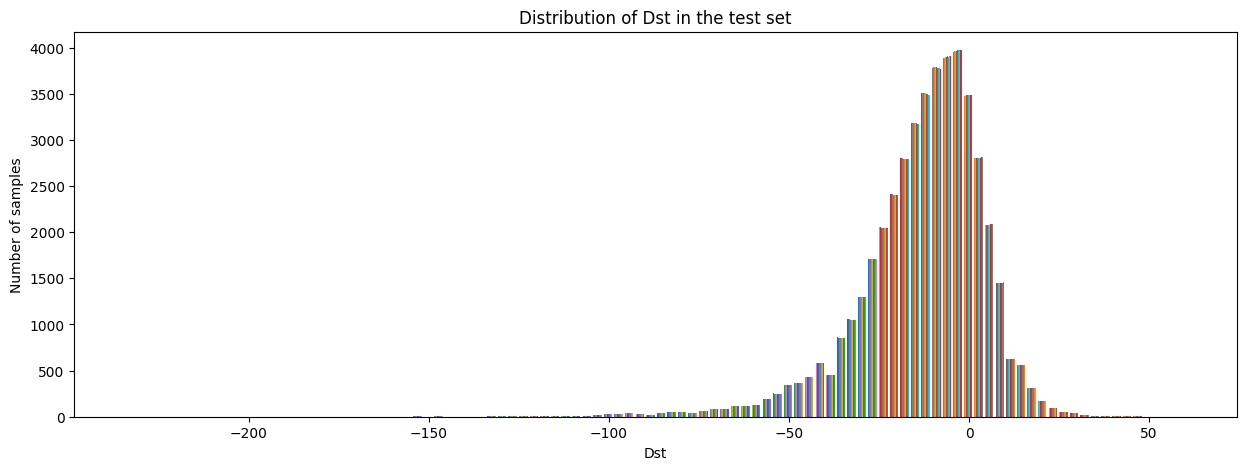

In [ ]:
# Plot the distribution of y_test
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(y_test[:, 0, :], bins=100)
ax.set_xlabel('Dst')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of Dst in the test set')
plt.show()


In [ ]:
# Create a dataframe with the mean forecast error for the Dst in each 
# Dst x F10.7 condition and each horizon. The horizon is given in days in the
# dataframe, but the actual horizon in the data is given in hours
data = []
for condition in all_conditions:
    if y_test_split.get(condition) is not None and \
    y_test_split.get(condition).shape[0] > 0:
        # Apply forecast_error to every horizon (1..horizon)
        fe_sfu = np.array([forecast_error(y_test_split[condition][:, 0, :],
                                        y_test_preds_split[condition][:, 0, :], 
                                        h) for h in range(1, horizon+1)]).astype(np.float64)
        fe_percent = np.array([percent_forecast_error(y_test_split[condition][:, 0, :],
                                                    y_test_preds_split[condition][:, 0, :], 
                                                    h) for h in range(1, horizon+1)]).astype(np.float64)
        # Aggregate the forecast every 24 hours (get mean and std)
        # TODO: This code breaks if the max horizon is not a multiple of 24
        fe_nT_mean = np.array([np.mean(fe_sfu[i:i+24]) for i in range(0, horizon, 24)])
        fe_nT_std = np.array([np.std(fe_sfu[i:i+24]) for i in range(0, horizon, 24)])
        #fe_percent_mean = np.array([np.mean(fe_percent[i:i+24]) for i in range(0, horizon, 24)])
        #fe_percent_std = np.array([np.std(fe_percent[i:i+24]) for i in range(0, horizon, 24)])
        # additional columns
        h_days = np.arange(1, (horizon // 24) + 1)
        n_samples = y_test_split[condition].shape[0]
        # Append the data to the list
        for h_day, mean, std in zip(h_days, fe_nT_mean, fe_nT_std):
            data.append((condition, h_day, mean, std, n_samples))
# Create the dataframe        
df_results = pd.DataFrame(data, columns=['condition', 'horizon_days', 
                                         'fe_nT_mean', 'fe_nT_std', 'n_samples'])
df_results.head(10)

,condition,horizon_days,fe_nT_mean,fe_nT_std,n_samples
0,G0_Low,1,-0.536725,14.026997,5185
1,G0_Low,2,-3.535431,15.939203,5185
2,G0_Low,3,-5.226856,17.712551,5185
3,G0_Low,4,-5.603970,18.125063,5185
4,G0_Low,5,-5.862962,18.987914,5185
5,G0_Low,6,-4.350699,18.643579,5185
6,G0_Moderate,1,0.758833,17.224798,30127
7,G0_Moderate,2,-1.128712,20.928980,30127
8,G0_Moderate,3,-1.873645,22.736646,30127
9,G0_Moderate,4,-1.881257,22.708888,30127


In [ ]:
# compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_paper = pd.read_csv('../data/benchmark_results_dst.csv', comment = '#')
df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']
# Rename mu with fe_nT_mean and sigma with fe_nT_std in the statistics column
df_results_paper['statistic'] = df_results_paper['statistic'].replace({
    'mu': 'fe_nT_mean', 
    'sigma': 'fe_nT_std'
    })
df_results_paper.head()

,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
0,G0_Low,fe_nT_mean,1.1077,1.1851,1.8191,1.9479,4.7670,4.9067
1,G0_Low,fe_nT_std,14.6264,15.3676,16.0768,16.6027,15.2969,15.5632
3,G0_Moderate,fe_nT_mean,8.8130,9.1455,9.5665,9.8593,10.1396,10.2912
4,G0_Moderate,fe_nT_std,18.2244,18.3000,18.9761,19.0591,19.2045,19.1569
6,G0_Elevated,fe_nT_mean,9.6871,8.8767,8.0980,8.0500,8.9239,9.4235


In [ ]:
# Convert the dfs with results into long format
df_results_long = pd.melt(df_results, id_vars=['condition', 'horizon_days'],
                            value_vars=['fe_nT_mean', 'fe_nT_std'],
                            var_name='statistic', value_name='value')
df_results_long.head()

,condition,horizon_days,statistic,value
0,G0_Low,1,fe_nT_mean,-0.536725
1,G0_Low,2,fe_nT_mean,-3.535431
2,G0_Low,3,fe_nT_mean,-5.226856
3,G0_Low,4,fe_nT_mean,-5.603970
4,G0_Low,5,fe_nT_mean,-5.862962


In [ ]:
df_results_paper_long = df_results_paper.melt(id_vars=['condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon_days+1)],
                                            var_name='horizon_days', value_name='value')
df_results_paper_long['horizon_days'] = df_results_paper_long['horizon_days'].str.replace(
    ' Days', '').astype(int)
df_results_paper_long.head()

,condition,statistic,horizon_days,value
0,G0_Low,fe_nT_mean,1,1.1077
1,G0_Low,fe_nT_std,1,14.6264
2,G0_Moderate,fe_nT_mean,1,8.8130
3,G0_Moderate,fe_nT_std,1,18.2244
4,G0_Elevated,fe_nT_mean,1,9.6871


In [ ]:
# Join the two dataframes (paper and ours) into one, merging on the condition and
# statistic. Right merge (paper)
df_results_merged = pd.merge(df_results_long, df_results_paper_long,
                            on=['condition', 'statistic', 'horizon_days'], how='right',
                            suffixes=('_ours', '_benchmark'))

df_results_merged.head()

,condition,horizon_days,statistic,value_ours,value_benchmark
0,G0_Low,1,fe_nT_mean,-0.536725,1.1077
1,G0_Low,1,fe_nT_std,14.026997,14.6264
2,G0_Moderate,1,fe_nT_mean,0.758833,8.8130
3,G0_Moderate,1,fe_nT_std,17.224798,18.2244
4,G0_Elevated,1,fe_nT_mean,1.265338,9.6871


In [ ]:
from swdf.plots import * 
# Bold the best values between ours and the benchmark
bolded_ours, bolded_benchmark = bold_best(
    df_results_merged['value_ours'].round(2),
    df_results_merged['value_benchmark'].round(2),
    higher_better=False, 
    bold_ref_too=True
)
df_print = df_results_merged.copy()
df_print['value_ours'] = bolded_ours
df_print['value_benchmark'] = bolded_benchmark
df_print.head()

df_print = df_print.pivot_table(index=['condition', 'horizon_days'],
                                columns='statistic',
                                values=['value_ours', 'value_benchmark'],
                                aggfunc=lambda x: x)

df_print.loc[:, ('value_ours', 'fe_nT_mean ± fe_nT_std')] = \
    df_print['value_ours']['fe_nT_mean'] + ' ± ' + df_print['value_ours']['fe_nT_std']
df_print.loc[:, ('value_benchmark', 'fe_nT_mean ± fe_nT_std')] = \
    df_print['value_benchmark']['fe_nT_mean'] + ' ± ' + df_print['value_benchmark']['fe_nT_std']
df_print = df_print.drop(columns=[('value_ours', 'fe_nT_mean'), ('value_ours', 'fe_nT_std'),
                                ('value_benchmark', 'fe_nT_mean'), ('value_benchmark', 'fe_nT_std')])


# Drop the level 0 of the columns, and rename the columns
df_print.columns = df_print.columns.droplevel(0)
df_print.columns = ['Ours', 'benchmark']

# Sort the values of the column condition so that the order is the same as in the
# array all_possible_dst_conditions (not all the conditions are present in the 
# dataframe)
df_print = df_print.reset_index()
df_print['condition'] = pd.Categorical(df_print['condition'], 
                                       all_conditions, ordered=True)
df_print = df_print.sort_values('condition')
# Escape the underscore in the condition names
df_print['condition'] = df_print['condition'].str.replace('_', '\_')
# Escape the column names
df_print.columns = df_print.columns.str.replace('_', '\_')

df_print.head()

,condition,horizon\_days,Ours,benchmark
17,G0\_Low,6,\textbf{-4.35} ± 18.64,4.91 ± \textbf{15.56}
16,G0\_Low,5,\textbf{-5.86} ± 18.99,4.77 ± \textbf{15.3}
15,G0\_Low,4,\textbf{-5.6} ± 18.13,1.95 ± \textbf{16.6}
14,G0\_Low,3,\textbf{-5.23} ± 17.71,1.82 ± \textbf{16.08}
13,G0\_Low,2,\textbf{-3.54} ± 15.94,1.19 ± \textbf{15.37}


In [ ]:
# Print as a Latex table
print(df_print.to_latex(index=False, escape=False, column_format='lccc', 
                        label='tab:dst_results', caption='Results for the DST task.'))

\begin{table}
\caption{Results for the DST task.}
\label{tab:dst_results}
\begin{tabular}{lccc}
\toprule
condition & horizon\_days & Ours & benchmark \\
\midrule
G0\_Low & 6 & \textbf{-4.35} ± 18.64 & 4.91 ± \textbf{15.56} \\
G0\_Low & 5 & \textbf{-5.86} ± 18.99 & 4.77 ± \textbf{15.3} \\
G0\_Low & 4 & \textbf{-5.6} ± 18.13 & 1.95 ± \textbf{16.6} \\
G0\_Low & 3 & \textbf{-5.23} ± 17.71 & 1.82 ± \textbf{16.08} \\
G0\_Low & 2 & \textbf{-3.54} ± 15.94 & 1.19 ± \textbf{15.37} \\
G0\_Low & 1 & \textbf{-0.54} ± \textbf{14.03} & 1.11 ± 14.63 \\
G0\_Moderate & 6 & \textbf{-1.73} ± 22.16 & 10.29 ± \textbf{19.16} \\
G0\_Moderate & 5 & \textbf{-2.35} ± 22.77 & 10.14 ± \textbf{19.2} \\
G0\_Moderate & 4 & \textbf{-1.88} ± 22.71 & 9.86 ± \textbf{19.06} \\
G0\_Moderate & 3 & \textbf{-1.87} ± 22.74 & 9.57 ± \textbf{18.98} \\
G0\_Moderate & 2 & \textbf{-1.13} ± 20.93 & 9.15 ± \textbf{18.3} \\
G0\_Moderate & 1 & \textbf{0.76} ± \textbf{17.22} & 8.81 ± 18.22 \\
G0\_Elevated & 1 & \textbf{1.27} ± 16.4 & 9.

In [ ]:
data = df_results_merged.copy()

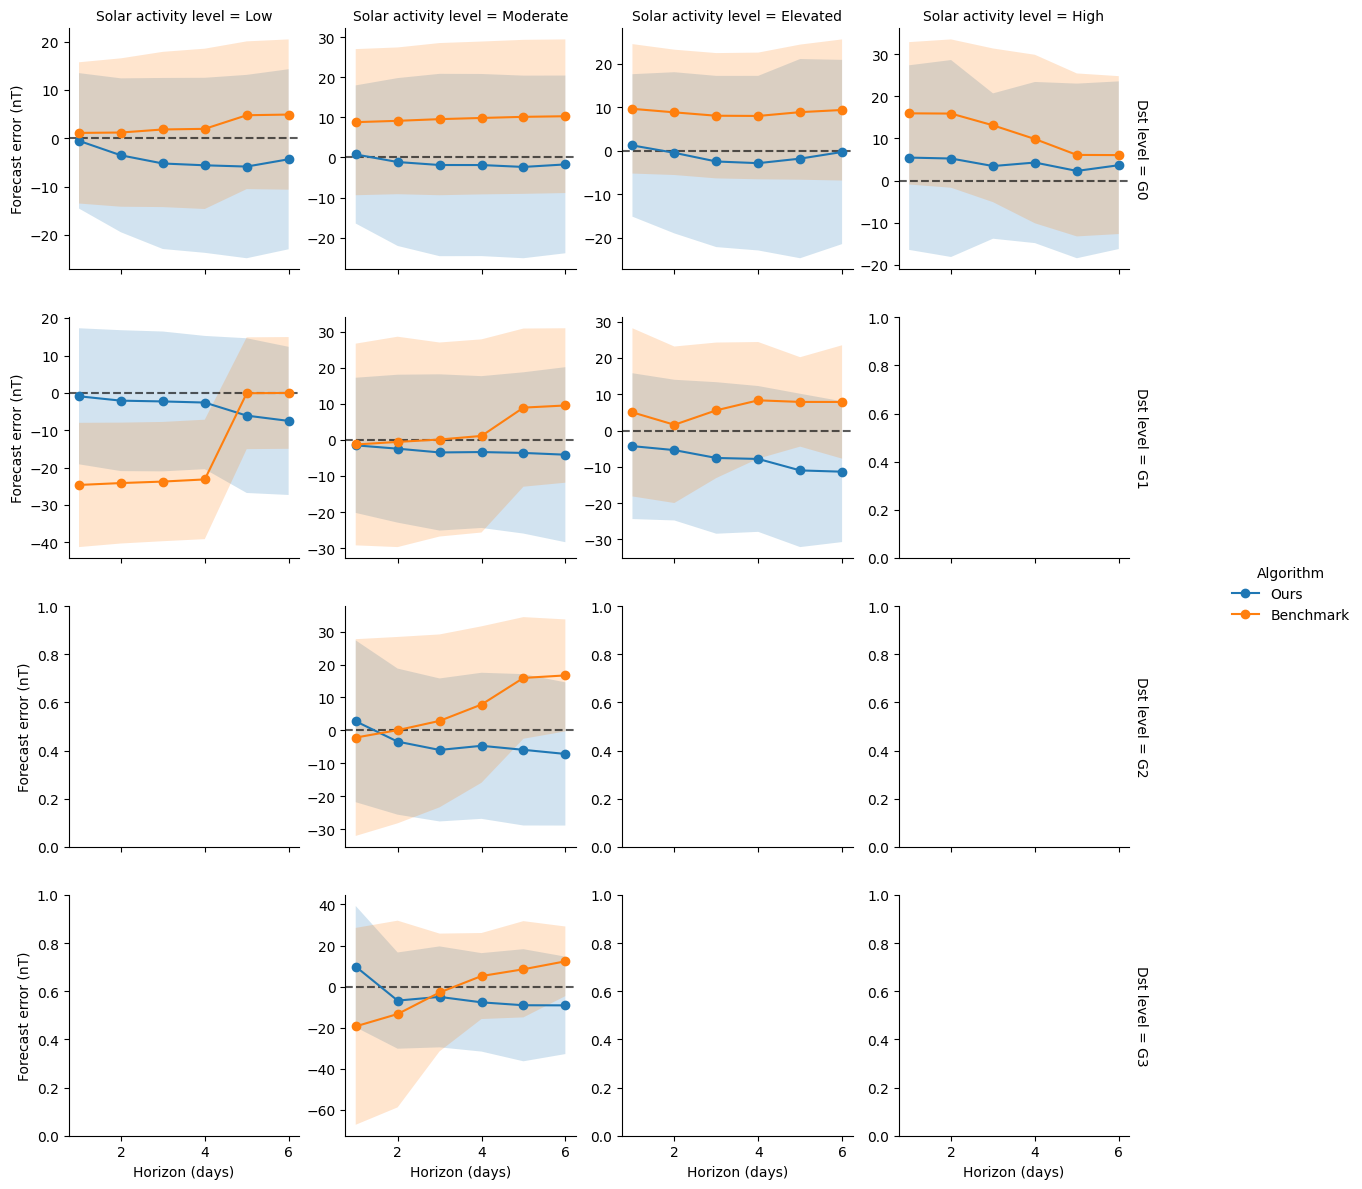

In [ ]:
# Preprocess the data
data[['Dst level', 'Solar activity level']] = data['condition'].str.split('_', expand=True)

# Separate mean and std dataframes
mean_df = data[data['statistic'] == 'fe_nT_mean'].copy()
std_df = data[data['statistic'] == 'fe_nT_std'].copy()

# Rename columns for merging
mean_df.rename(columns={'value_ours': 'mean_ours', 'value_benchmark': 'mean_benchmark'}, inplace=True)
std_df.rename(columns={'value_ours': 'std_ours', 'value_benchmark': 'std_benchmark'}, inplace=True)

# Melt the data to a long format
melted_mean_data = pd.melt(mean_df, id_vars=['Dst level', 'Solar activity level', 'horizon_days'], 
                           value_vars=['mean_ours', 'mean_benchmark'], 
                           var_name='algorithm', value_name='mean')

melted_std_data = pd.melt(std_df, id_vars=['Dst level', 'Solar activity level', 'horizon_days'], 
                          value_vars=['std_ours', 'std_benchmark'], 
                          var_name='algorithm', value_name='std')

# Correct the 'algorithm' column in the std melted dataframe
melted_std_data['algorithm'] = melted_std_data['algorithm'].str.replace('std', 'mean')

# Merge the mean and std melted dataframes
melted_data = pd.merge(melted_mean_data, melted_std_data, on=['Dst level', 
                                                              'Solar activity level', 'horizon_days', 'algorithm'])

# Create the faceted line charts
g = sns.FacetGrid(melted_data, row='Dst level', col='Solar activity level', hue='algorithm', 
                  margin_titles=True, sharey=False)

def plot_func(x, y1, y2, **kwargs):
    plt.plot(x, y1, marker='o', **kwargs)
    plt.fill_between(x, y1 - y2, y1 + y2, alpha=0.2)

g.map(plt.axhline, y=0, ls='--', c='black', alpha=0.4)  # Add this line
g.map(plot_func, 'horizon_days', 'mean', 'std')

g.set_xlabels("Horizon (days)")
g.set_ylabels("Forecast error (nT)")
g.add_legend(title='Algorithm')

# Change legend labels
new_labels = ['Ours', 'Benchmark']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(wspace=.2, hspace=.2)
plt.show()
